# Illumination Correction of NF1 Images

## Import libraries

In [1]:
import sys
import numpy as np
import matplotlib
import pathlib
from matplotlib import pyplot as plt
from pathlib import Path
import os
import skimage

# explicit import to PyBaSiC due to not having package support
sys.path.append("./PyBaSiC/")
import pybasic

## Create path and load in images
The directory set up used for this experiment goes as such:
```

├── NF1_SchwannCell_data/
│   ├── 1_preprocessing_data/
│   │   ├── PyBaSiC_Pipelines/
│   │   │   ├── NF1_Channels/
│   │   │   │   ├── DAPI/ or GFP/ or RFP/

```

In [2]:
channel_path = '../PyBaSiC_Pipelines/NF1_Channels/RFP/'

# The for loop is running through the files within the folder designated by channel_path and will only take the names of the images and strips the ".tif"
# which leaves the image name that helps with identification of cells (genotype)

all_files = os.listdir(channel_path)
file_ext = ".tif"
image_files = []
for file in all_files:
    if file.endswith(file_ext):
        image_files.append(file.strip(file_ext))
image_files.sort()
channel_images = pybasic.tools.load_data(channel_path, '.tif', verbosity = True)

0 / 32
10 / 32
20 / 32
30 / 32


## Run PyBaSiC to calculate the flatfield and darkfield

In [3]:
flatfield, darkfield = pybasic.basic(channel_images, darkfield=True)

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5
reweighting_iter: 6
reweighting_iter: 7
reweighting_iter: 8
reweighting_iter: 9
reweighting_iter: 10


## Displays the flatfield and darkfield that will be applied to the images

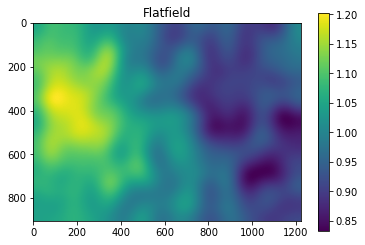

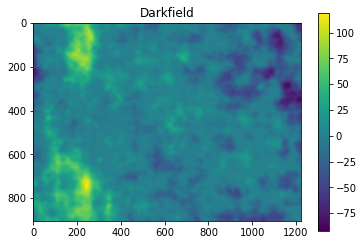

In [4]:
# Based on documentation from the developers, it is recommended to manually check the flatfield function created using the functions below.
# If the flatfield looks smooth, then the correction will be done well.
# If it is noisey, then there is likely an issue with the correction.
# Source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5472168/

plt.title('Flatfield')
plt.imshow(flatfield)
plt.colorbar()
plt.show()
plt.title('Darkfield')
plt.imshow(darkfield)
plt.colorbar()
plt.show()

## Run illumination correction

In [5]:
channel_images_corrected = pybasic.correct_illumination(
    images_list = channel_images, 
    flatfield = flatfield, 
    darkfield = darkfield,
)

## Conversion of Corrected Images

In [6]:
# The default output for the corrected images was not compatable with downstream processes which required code to convert the images to `8-bit`. This code was
# utlized from Mitocheck Data Project - Preprocessing Training Data {https://github.com/WayScience/mitocheck_data/blob/main/1.preprocess_data/preprocess_training_data.ipynb}

corrected_images_coverted = np.array(channel_images_corrected)
corrected_images_coverted[corrected_images_coverted<0] = 0 # makes the negatives 0
corrected_images_coverted = corrected_images_coverted / np.max(corrected_images_coverted) # normalize the data to 0 - 1
corrected_images_coverted = 255 * corrected_images_coverted # Scale by 255
corrected_images = corrected_images_coverted.astype(np.uint8)

## Use `for` loop that adds suffix to corrected images and downloads them

In [7]:
# Recommended to add a suffix that will indicate the which type of image it is, especially if the raw and corrected images look the same to the naked eye.

for i, image in enumerate(corrected_images):
    orig_file = image_files[i]
    new_filename = f'../PyBaSiC_Pipelines/NF1_Channels/RFP_Corrected/{orig_file}_IllumCorrect.tif'
    skimage.io.imsave(new_filename, image)